<a href="https://colab.research.google.com/github/muraliadithya/vdp/blob/master/demo_vdp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [1]:
# This notebook builds the YOLO model assuming you have a GPU runtime.
# Make sure you have a GPU runtime before running this! (Runtime > Change Runtype Type > GPU)
%%capture
%cd /content/
!git clone https://github.com/muraliadithya/vdp.git vdp
%cd /content/vdp/natscene_inference/darknet/
!./build.sh
%cd /content/vdp
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights
!pip install z3-solver
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import io
import requests
import shutil
import urllib
import os
%matplotlib inline

In [1]:
!ls /content/vdp/data/demo_images/

In [3]:
#@title ## Constructing a Visual Discrimination Puzzle.
#@markdown A VDP consists of a set of example and candidate images where *one* candidate shares some concept with *all* the example images. VDPs are rather interesting because solving a VDP puzzle requires both, "system 1" thinking and "system 2" thinking (read more [here](https://atharvas.github.io/static/VDP22.pdf) and [here](https://www.scientificamerican.com/article/kahneman-excerpt-thinking-fast-and-slow/)).

#@markdown  In this document we'll go through a neuro-symbolic approach to try to solve a VDP. We will make a VDP, process the images with an object detector, and solve the puzzle with the predictions generated. Let's get started!!

#@markdown ---
#@markdown ## VDP Puzzle

#@markdown ### Example Images
example_0 = "/content/vdp/data/demo_images/example_0.jpg" #@param {type:"string"}
example_1 = "/content/vdp/data/demo_images/example_1.jpg" #@param {type:"string"}
example_2 = "/content/vdp/data/demo_images/example_2.jpg" #@param {type:"string"}


#@markdown ### Candidate Images
candidate_0 = "/content/vdp/data/demo_images/candidate_0.jpg" #@param {type:"string"}
candidate_1 = "/content/vdp/data/demo_images/candidate_1.jpg" #@param {type:"string"}
candidate_2 = "/content/vdp/data/demo_images/candidate_2.jpg" #@param {type:"string"}

#@markdown Feel free to replace any of these images with a valid URL! These images are under CC w/ attribution. You can find the attribution at `/content/vdp/data/demo_images/attribution.txt`. 

def pull_image(image_uri, save_path):
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path))

    try:
      p = urllib.parse.urlparse(image_uri)
      assert all([p.scheme, p.netloc]), "Invalid URL"
      urllib.request.urlretrieve(image_uri, save_path)
      # request = requests.get(image_uri, stream=True)
      # assert request.status_code == 200, f"Couldn't retrieve URL. Error {request.status_code}"
      # request.raw.decode_content = True
      # with open(save_path,'wb') as fp:
      #     shutil.copyfileobj(request.raw, fp)
    except Exception as e:
      print(f"{image_uri} not downloadable ({e}). Finding in local dir instead.")
      shutil.copyfile(image_uri, save_path)

# Process and plot the images.
%cd /content/vdp

examples = [example_0, example_1, example_2]
candidates = [candidate_0, candidate_1, candidate_2]

puzzle = dict(name="test", examples=examples, candidates=candidates)

for i, current_uri in enumerate(puzzle['examples']):
    ext = os.path.splitext(current_uri)[1]
    new_uri = f"/content/images/example_{i}{ext}"
    pull_image(current_uri, new_uri)
    puzzle['examples'][i] = new_uri

for i, current_uri in enumerate(puzzle['candidates']):
    ext = os.path.splitext(current_uri)[1]
    new_uri = f"/content/images/candidate_{i}{ext}"
    pull_image(current_uri, new_uri)
    puzzle['candidates'][i] = new_uri

from utils.common import to_txt
to_txt(puzzle['examples'] + puzzle['candidates'], "/content/images/images.txt")

/content/vdp


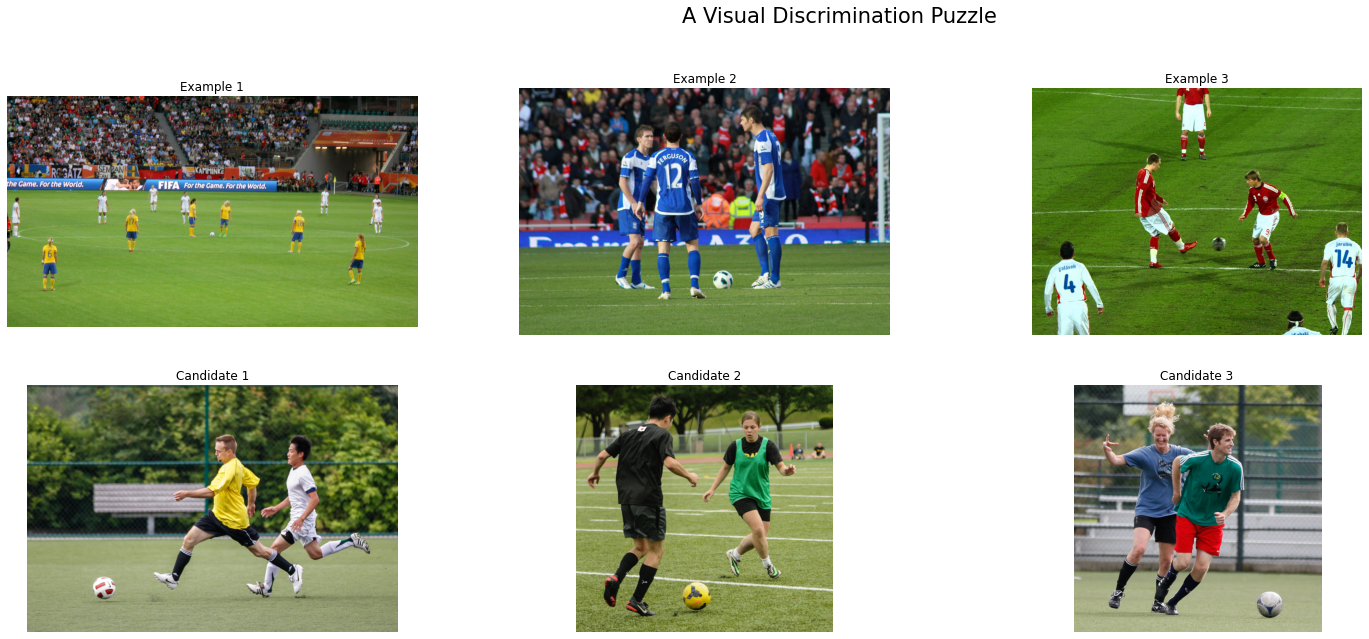

In [4]:
def plot_vdp(example_images, candidate_images):
    fig, ax = plt.subplots(2, max(len(example_images), len(candidate_images)), figsize=(25, 10))
    fig.suptitle("A Visual Discrimination Puzzle", fontsize=21, ha='left', va='center')

    for i, example in enumerate(example_images):
        ax[0, i].imshow(example)
        ax[0, i].axis('off')
        ax[0, i].set_title(f"Example {i + 1}")

    for i, candidate in enumerate(candidate_images):
        ax[1, i].imshow(candidate)
        ax[1, i].axis('off')
        ax[1, i].set_title(f"Candidate {i + 1}")
    return fig, ax

example_images = [io.imread(img_pth) for img_pth in puzzle['examples']]
candidate_images = [io.imread(img_pth) for img_pth in puzzle['candidates']]

fig, ax = plot_vdp(example_images, candidate_images)
fig.show()

In [17]:
# Processing the images with darknet / YOLOv4
%cd /content/vdp/natscene_inference/darknet/
import darknet
from darknet_images import image_classification, image_detection

image_paths = examples + candidates

network, class_names, class_colors = darknet.load_network(
    "/content/vdp/natscene_inference/darknet/cfg/yolov4.cfg",
    "/content/vdp/natscene_inference/darknet/cfg/coco.data",
    "/content/vdp/yolov4.weights",
    batch_size=1
)


def sanitize_bboxes(detections):
    return dict(objects=[dict(name=label, confidence=confidence, relative_coordinates=dict(center_x=(x+(w/2)), center_y=(y+(h/2)),  width=w, height=h), id=f"{i}_{label}")  for i, (label, confidence, (x, y, w, h)) in enumerate(detections)])

detect = lambda img_path : image_detection(img_path, network, class_names, class_colors, thresh=0.75) # returns (image, predictions)
puzzle['processed_examples'] = [detect(img) for img in puzzle['examples']]
puzzle['processed_candidates'] = [detect(img) for img in puzzle['candidates']]

puzzle['processed_examples'] = list(map(lambda x : (x[0], sanitize_bboxes(x[1]) ), puzzle['processed_examples']))
puzzle['processed_candidates'] = list(map(lambda x : (x[0], sanitize_bboxes(x[1]) ), puzzle['processed_candidates']))

del network

/content/vdp/natscene_inference/darknet


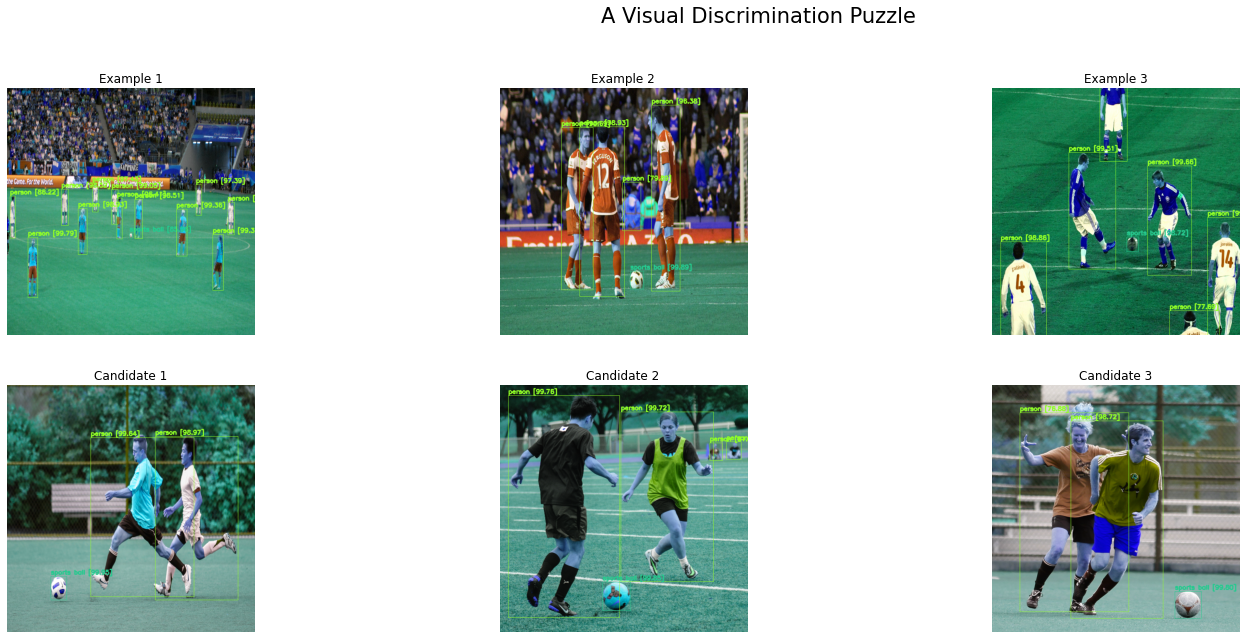

In [18]:
example_images = [img for (img, preds) in puzzle['processed_examples']]
candidate_images = [img for (img, preds) in puzzle['processed_candidates']]

fig, ax = plot_vdp(example_images, candidate_images)
fig.show()

In [20]:
%cd /content/vdp/
from natscene_inference.vdp.ir import YOLOIR
from utils.common import to_json

output_path = "/content/ir/"
coco_names = "/content/vdp/natscene_inference/darknet/data/coco.names"
ir_processor = YOLOIR(output_path, coco_names, use_cache=False)

for i, (img, predictions) in enumerate(puzzle['processed_examples']):
    out_pth = f"/content/processed/train/example_{i}.json"
    if not os.path.exists(os.path.dirname(out_pth)): os.makedirs(os.path.dirname(out_pth))
    fo_model = ir_processor.get_yolo_fo_model(predictions)
    to_json(fo_model, out_pth)

for i, (img, predictions) in enumerate(puzzle['processed_candidates']):
    out_pth = f"/content/processed/test/candidate_{i}.json"
    if not os.path.exists(os.path.dirname(out_pth)): os.makedirs(os.path.dirname(out_pth))
    fo_model = ir_processor.get_yolo_fo_model(predictions)
    to_json(fo_model, out_pth)




/content/vdp


In [21]:
from natscene_driver import run_solver, NatSceneConstants

run_solver(vdp_flags = "- 3 --autotune", inference_result = "/content/processed", output_file = "/content/processed/solver.out", constants = NatSceneConstants())

LOG: exec_cmd(timeout         60         python         vdp_solver/scripts/vdpsolve.py         /content/processed         - 3 --autotune)


In [22]:
!cat /content/processed/solver.out

Candidate: c1
Concept: Exists q0: person. Exists q1: sports ball. Exists q2: person. left(q1,q0) AND left(q2,q1)
Candidate Name: /content/processed/test/candidate_1.json


